<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab    


*Authors:*  
 - Joseph Nelson (DC)        
 - Boom Devahastin Na Ayudhya (NYC)     
 - Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")


In [3]:
data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [4]:

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [5]:
data.index = pd.to_datetime(data.index)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


In [7]:
data.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [8]:
#weekly sale Data frame created
mask = data['Store'] == 1
data = data[mask]


Weekly_Sales = pd.DataFrame(data['Weekly_Sales'].groupby(data.index).sum())

In [9]:
Weekly_Sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

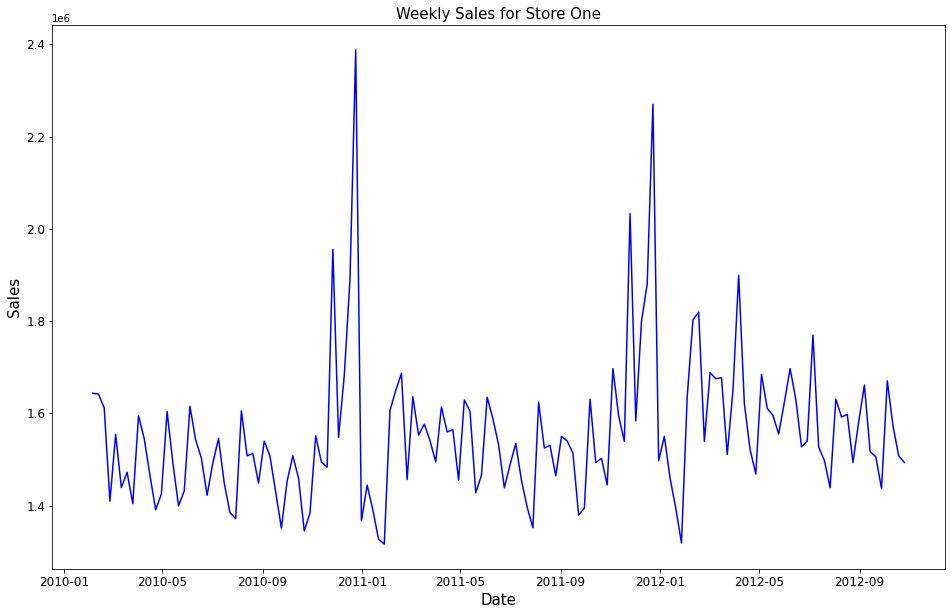

In [10]:
# To create a plot 
plt.figure(figsize=(16,10))


plt.plot(Weekly_Sales, c ='blue')


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.title('Weekly Sales for Store One', fontsize=15);

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

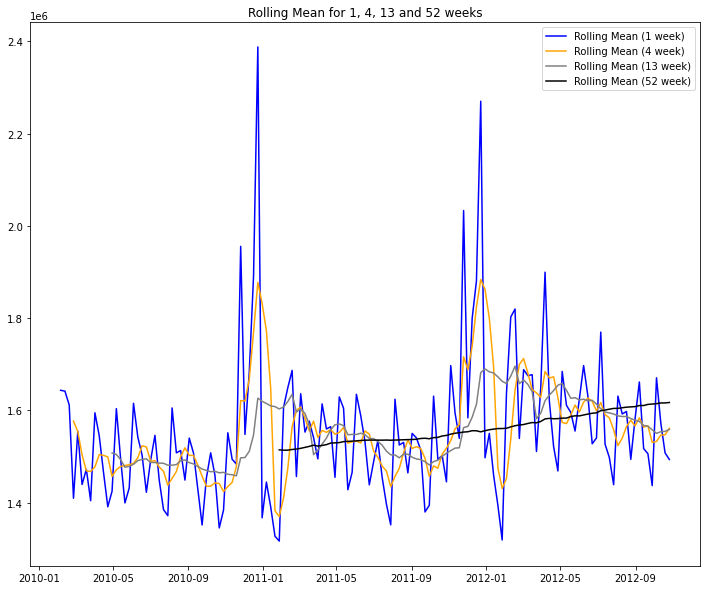

In [11]:
# Plot with rolling of 1, 4 , 13, and 52

rolmean1  = Weekly_Sales.rolling(window = 1).mean()
rolmean4  = Weekly_Sales.rolling(window = 4).mean()
rolmean13 = Weekly_Sales.rolling(window = 13).mean()
rolmean52 = Weekly_Sales.rolling(window = 52).mean()

plt.figure(figsize=(12,10))
plt.plot(rolmean1, color='blue', label='Rolling Mean (1 week)')
plt.plot(rolmean4, color='orange', label='Rolling Mean (4 week)')
plt.plot(rolmean13, color='grey', label='Rolling Mean (13 week)')
plt.plot(rolmean52, color='black', label='Rolling Mean (52 week)')
plt.legend(loc='best')

plt.title('Rolling Mean for 1, 4, 13 and 52 weeks')
plt.show()

**2c. What can you say about patterns in the data based on the rolling mean plot above?**

*Answer:*

spikes around January and February and increases for holiday spending in November and December.
spikes are consistent and going to decrease around early yearly.
week and month and quarter is ploted with rolling.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [12]:
print(f'Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=1),4)}')
print(f'Autocorrelation between Weekly Sales and 2-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=2),4)}')
print(f'Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=52),4)}')


Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: 0.3022
Autocorrelation between Weekly Sales and 2-lag Weekly_Sales: 0.1274
Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: 0.8954


**3b. What can you say about the series based on these autocorrelations?**

Answer:
Autocorrelation shows a fair amount of influence on weekly sales compared to the prior week.
Week two looks further away from the current week. it's likely to consider that a lag would be less correlated with the current week's sales.
Week-52 lag of sales is strongly correlated and there might be a seasonal influence on sales.

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

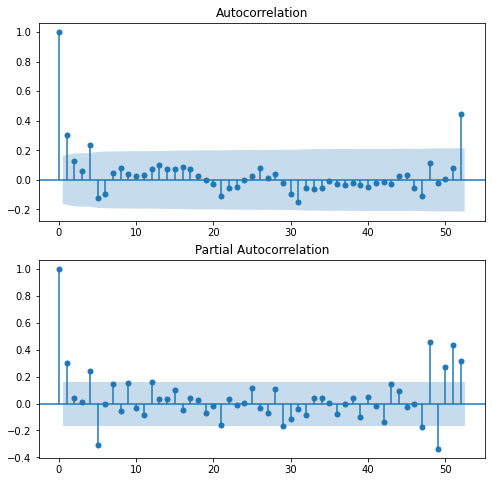

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(Weekly_Sales, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Weekly_Sales, lags=52, ax=ax2);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer:
Blue space show a 95% of confidence interval and the points inside the blue space are likely to be noise (not correlation). Further investigation will considered for the points outside the interval.

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer:
There seems correlation at 1 week, at 4 or 5 weeks, and right around 48-52 weeks.

The values of $p$ and $q$ may be determined or any seasonal component may fit.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data. You can do this using `train_test_split` with a specific parameter, or can manually define it how it is set up below.

In [14]:
print(f'Number of observations: {len(Weekly_Sales)}')
print(f'Number of training observations: {round(len(Weekly_Sales) * 0.75)}')
print(f'Number of testing observations: {len(Weekly_Sales) - round(len(Weekly_Sales) * 0.75)}')

train = Weekly_Sales.iloc[:108,]

test = Weekly_Sales.iloc[108:,]

Number of observations: 143
Number of training observations: 107
Number of testing observations: 36


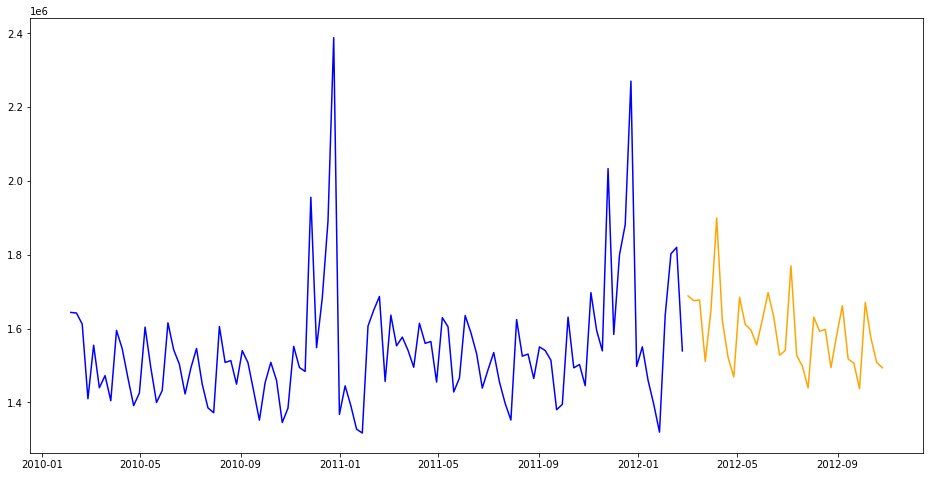

In [15]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

    
train_test_plot(train, test)

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [16]:

train_values = train['Weekly_Sales'].values
train_dates = train.index

AR1 = AR(train_values, train_dates).fit()

test_values = test['Weekly_Sales'].values
test_dates  = test.index

start = test.index[0]
end = test.index[-1]

AR1_pred = AR1.predict(start = start,
                       end = end)

In [17]:

date_list =  pd.date_range(start, periods=35, freq ='W')
preds = pd.DataFrame(AR1_pred, index=date_list, columns = ['Weekly Sales'])

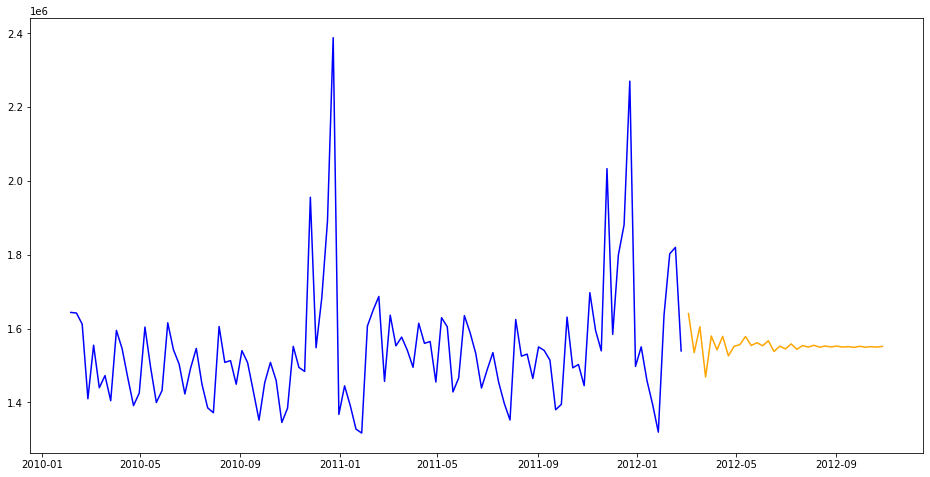

In [18]:
train_test_plot(train, preds)

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [19]:

from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_values, preds)
print(f'MSE: {round(error, 2)}')

MSE: 9834237361.27


**6c. How effective do you think this `AR(1)` model is?**

In [20]:

print(f'Minimum Sales: {round(Weekly_Sales["Weekly_Sales"].min(),2)}')
print(f'Maximum Sales: {round(Weekly_Sales["Weekly_Sales"].max(),2)}')
print(f'MSE relative to minimum values in series: {round(error / Weekly_Sales["Weekly_Sales"].min(),2)}.')
print(f'MSE relative to maximum values in series: {round(error / Weekly_Sales["Weekly_Sales"].max(),2)}.')

Minimum Sales: 1316899.31
Maximum Sales: 2387950.2
MSE relative to minimum values in series: 7467.72.
MSE relative to maximum values in series: 4118.28.


Answer:
the ratio of the mean error looks not any bad. earlier predictions are less incorrect than later. there might need some improvement.


#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

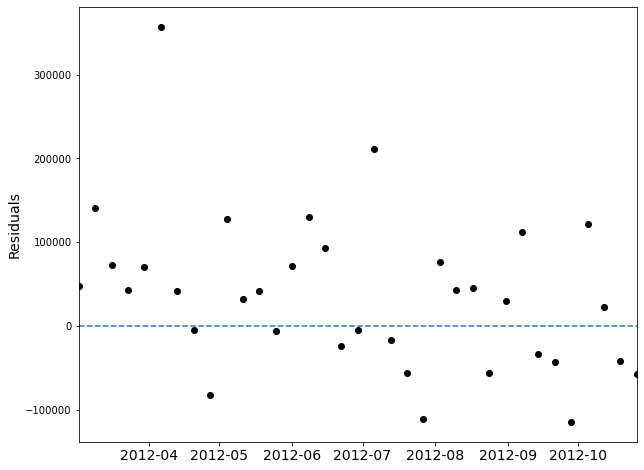

In [21]:

plt.figure(figsize=(10,8))

resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

plt.scatter(test['Weekly_Sales'].index, resids, c ='black')

plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

plt.xticks(fontsize=14)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=10)
plt.ylabel('Residuals', fontsize = 14);

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer:
The prediction is off more than others in some days, which can be model limit of limited to specific those days.
Early period is predicted too low whereas later time period is predicted close to accurate.


#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

Training MSE: 25669024679.47771
Testing MSE: 11333863107.47419


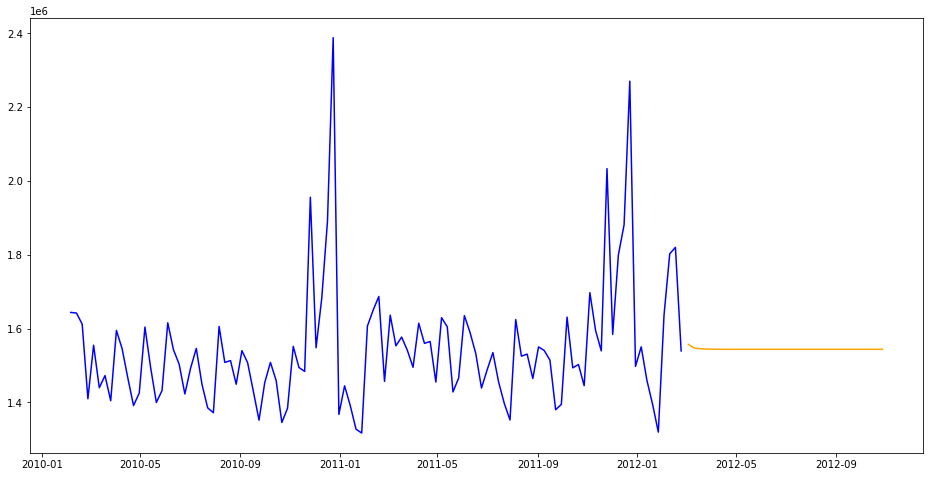

In [22]:

AR2 = ARIMA(endog = train_values,
            dates = train_dates,
            order = (2,0,0)).fit()

AR2_pred = AR2.predict(start = start,
                       end = end)

print(f'Training MSE: {mean_squared_error(train_values, AR2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR2_pred)}')

preds = pd.DataFrame(AR2_pred, index=date_list, columns = ['Weekly Sales'])

train_test_plot(train, preds)


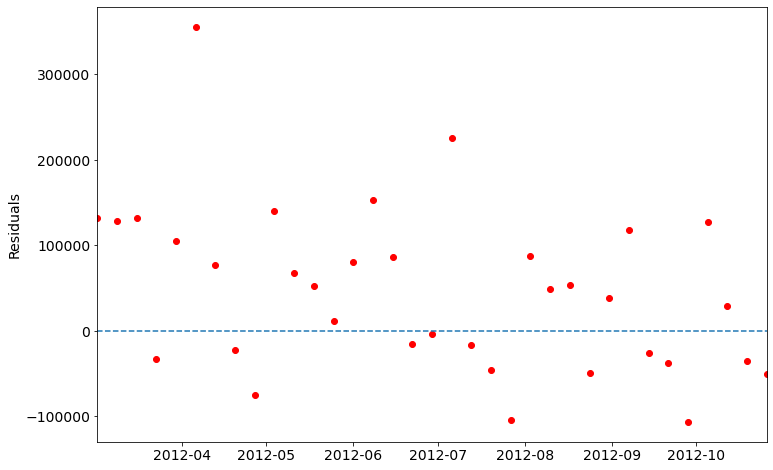

In [23]:

plt.figure(figsize=(12,8))

resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')


plt.xticks(fontsize=14)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 14);

**8b. How did your results change?**

Answer:
These results are not good. it seems model remove variation in the sales, creating a set of flat predictions.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

Training MSE: 21365551897.621166
Testing MSE: 11347924130.120018


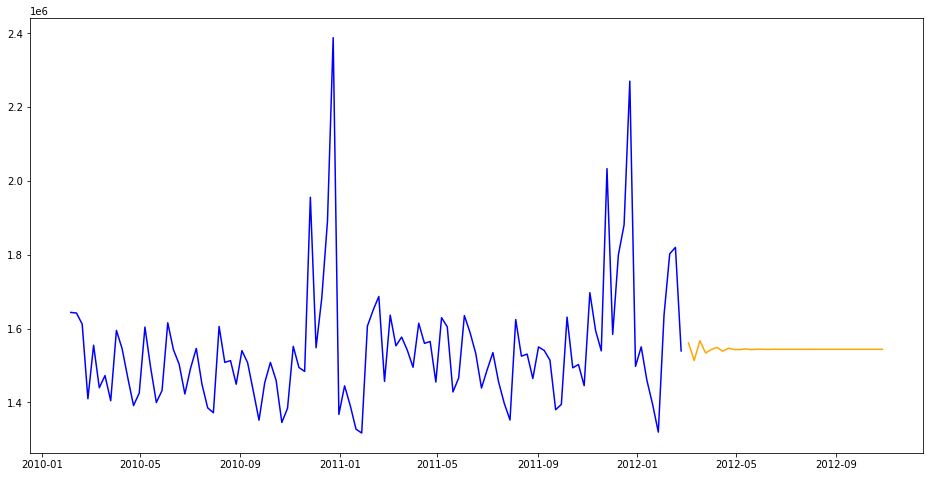

In [24]:

AR2_2 = ARIMA(endog = train_values,
              dates = train_dates,
              order = (2,0,2)).fit()

AR2_2_pred = AR2_2.predict(start = start,
                           end = end)

print(f'Training MSE: {mean_squared_error(train_values, AR2_2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR2_2_pred)}')

preds = pd.DataFrame(AR2_2_pred, index=date_list, columns = ['Weekly Sales'])

train_test_plot(train, preds)

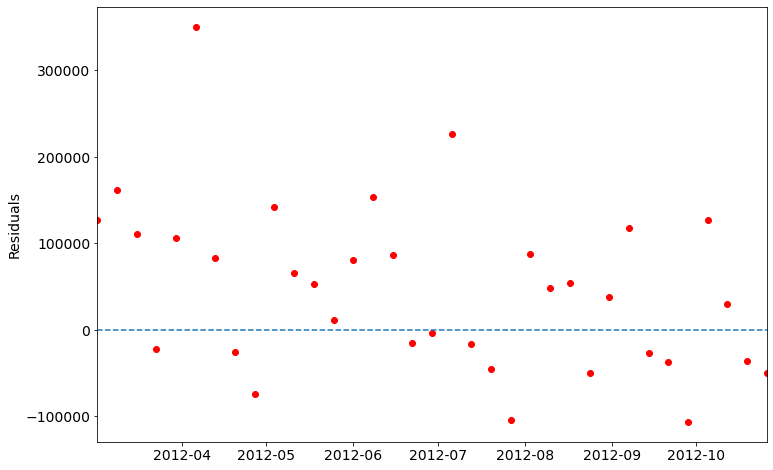

In [25]:

plt.figure(figsize=(12,8))

resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')


plt.xticks(fontsize=14)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 14);

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer:
MSE and graph are not good in the AR(2) and ARMA(2,2) models than when we fit an AR(1) model. The residuals are also worse in both AR(2) and ARMA(2,2) models.

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

### I learn this method from Lecture notes and particularly the function from machine learning mastery notes. This is because i was already working on time series work on my group project (in last 3/4 weeks).
1- https://machinelearningmastery.com/

In [26]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

# Run ADF test on original (non-differenced!) data.
adfuller(data['Weekly_Sales'])

(-3.7613267524635847,
 0.003328723751009086,
 38,
 10205,
 {'1%': -3.430990954987035,
  '5%': -2.861823264603541,
  '10%': -2.566920776605314},
 206513.8482101402)

In [ ]:
# from lecture notes

In [29]:
def interpret_dftest(data):
    data_output = pd.Series(data[0:2], index=['Test Statistic','p-value'])
    return data_output

In [30]:
interpret_dftest(adfuller(data['Weekly_Sales']))

Test Statistic   -3.761327
p-value           0.003329
dtype: float64

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer:
p to 5.27x 10^-11 and 0.05 = alpha, we reject $H_0$ that our data are not stationary and accept $H_A$ that our data are stationary. This means we can fit an ARIMA model to this data without differencing.

#### 10. Differenced Data

Regardless of what you found above, now we're going to take a look at differenced data.

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [27]:
Weekly_Sales['diff_1'] = Weekly_Sales['Weekly_Sales'].diff()
Weekly_Sales['diff_2'] = Weekly_Sales['Weekly_Sales'].diff(2)
Weekly_Sales['diff_3'] = Weekly_Sales['Weekly_Sales'].diff(3)
Weekly_Sales['diff_4'] = Weekly_Sales['Weekly_Sales'].diff(4)
Weekly_Sales.head()

,Weekly_Sales,diff_1,diff_2,diff_3,diff_4
Date,,,,,
2010-02-05,1643690.90,NaN,NaN,NaN,NaN
2010-02-12,1641957.44,-1733.46,NaN,NaN,NaN
2010-02-19,1611968.17,-29989.27,-31722.73,NaN,NaN
2010-02-26,1409727.59,-202240.58,-232229.85,-233963.31,NaN
2010-03-05,1554806.68,145079.09,-57161.49,-87150.76,-88884.22


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [32]:
#adfuller(data['Weekly_Sales'].diff(1))
data['Weekly_Sales'] = data['Weekly_Sales'].diff(1)
interpret_dftest(adfuller(data['Weekly_Sales'].dropna()))

Test Statistic   -20.595926
p-value            0.000000
dtype: float64

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer:
Data seems stationary and i dont think that differencing is good.

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer:
Since the data seems more stationary, i think one can try an ARIMA with a differenced.

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Using whichever metric(s) you think best suit this problem (don't forget to import them above!), evaluate your model on the training and testing sets and generate a residual plot.**

In [ ]:


ARIMA_2_1_2 = ARIMA(endog = train_values, dates = train_dates, order = (2,1,2)).fit()

ARIMA_2_1_2_pred = ARIMA_2_1_2.predict(start=start, end = end)

mean_squared_error(test_values, ARIMA_2_1_2_pred)

In [ ]:
train_test_plot(test_values, ARIMA_2_1_2_pred)

**11b. Interpret the results from the last answer.**


Answer: The value is very high and seems confusing to me. Also differnece between blue and orange is large. I think using SARIMAX Model may help to improve the results.

#### 12.  BONUS [12a-12b]: SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

**12b. How did your best SARIMAX model perform?**

Answer:

### 13. Your Best Model

**13a. How did you decide this was your best model? How does your model perform at predicting weekly sales moving forward? Please use the metrics/visuals you included above to support your answer.** 

Answer: model with minimum of MSE would be best according to my thought.

**13b. How might you improve this model?**

Answer: I may request for more data or may be we can tune parameters.

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer:

## References:

### 1- https://machinelearningmastery.com/
### 2- https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis/
### 3- codes are used from lectures and solutions of lectures: 10.01, 10.02, 10.03, 10.04
### 4- codes are used from lab review solution notes: lab-review-in-class == 10.02